In [7]:
import numpy as np
import pandas as pd
import matplotlib
print(matplotlib.__version__)
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines
from glob import glob
from collections import Counter
#import ns
import history_cmc as hic
import math
import scipy
#from scipy.interpolate import interp1d
#from scipy import stats
import matplotlib.cm as cm
import matplotlib as mpl
import random
from random import shuffle
import gzip
import sys
import astropy
from astropy import units
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
print('done')

#import gw_ecc_calc as gwcalc
#import unit_convert as uc
#import merger_rate_calculator as mr
#import ns_tidalcapture as tc
import conversions
import dynamics as dyn
print('done')

%matplotlib inline

matplotlib.rcParams.update({'font.size': 24})

sys.path.insert(1, '/fs/lustre/cita/claireshiye/cmctoolkit')
import cmctoolkit as cmct
      
twopi=2.*np.pi
yearsc=3.1557*10**7
Kconst=9.87*10**-48 ##yr/G^2
Gconst=6.674*10**-8 ##cm3*g-1*s-2
Gconst_sun = 4.30091*10**-3 ##pc*M_sun**-1*(km/s)^2
clight=3*10**10 ##cm/s
Msun=2*10**33 ##gram
AU=1.496*10**13  ##cm
AU_Rsun=214.93946938362 ##AU to R_sun
PC=3.086*10**18  ##cm
PC_Rsun = 44334448.0068964 ##pc to R_sun

3.5.2
done
done


/fs/lustre/cita/claireshiye/CMC-COSMIC/CMC/ngc1851/N1.2e6rv0.5z0.0013rg2/
11738.3
/fs/lustre/cita/claireshiye/CMC-COSMIC/CMC/ngc1851/N1.3e6rv0.5z0.0013rg20/
10907.8


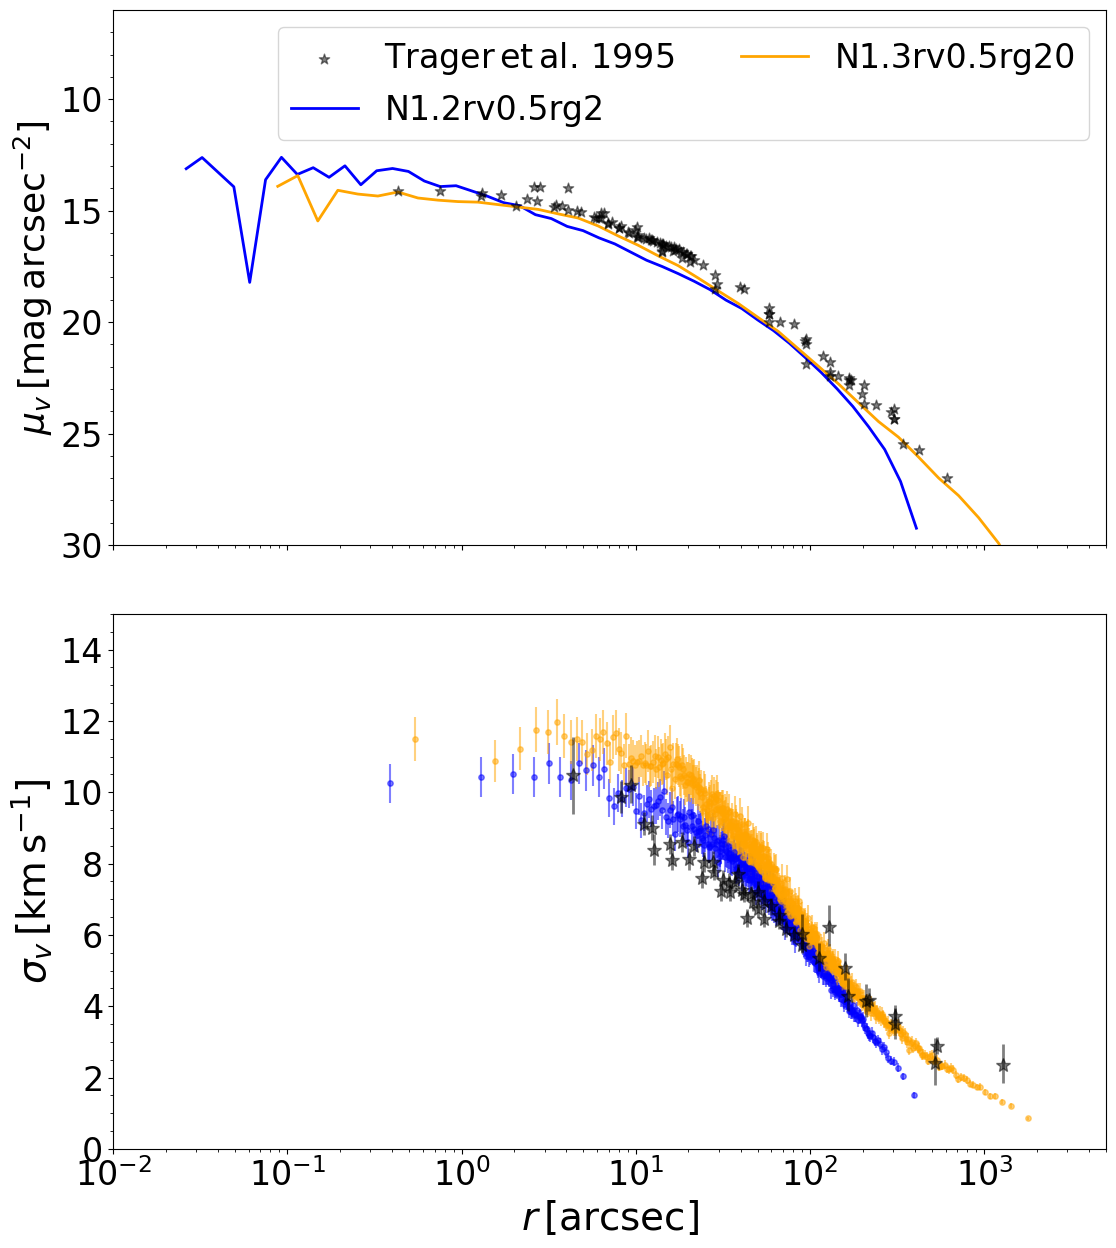

In [2]:
#path = ['/fs/lustre/cita/claireshiye/CMC-COSMIC/CMC/ngc1851/N1.2e6rv0.5z0.0013rg2/', 
#        '/fs/lustre/cita/claireshiye/CMC-COSMIC/CMC/ngc1851/N1.3e6rv0.5z0.0013rg2/',
#        '/fs/lustre/cita/claireshiye/CMC-COSMIC/CMC/ngc1851/N1.6e6rv0.4z0.0013rg1/',
#        '/fs/lustre/cita/claireshiye/CMC-COSMIC/CMC/ngc1851/N1.6e6rv0.5z0.002rg20/',
#        '/fs/lustre/cita/claireshiye/CMC-COSMIC/CMC/ngc1851/N2e6rv1z0.0013rg1/',
#        '/fs/lustre/cita/claireshiye/CMC-COSMIC/CMC/ngc1851/N1.3e6rv0.5z0.0013rg20/']
#prefix = ['initial4', 'initial6', 'initial14', 'initial13', 'initial20', 'initial11']

path = ['/fs/lustre/cita/claireshiye/CMC-COSMIC/CMC/ngc1851/N1.2e6rv0.5z0.0013rg2/', 
        '/fs/lustre/cita/claireshiye/CMC-COSMIC/CMC/ngc1851/N1.3e6rv0.5z0.0013rg20/']
prefix = ['initial4', 'initial11']
##First Check

##Surface brightness and velocity dispersion profiles
###Observations###
R_sun_obs=11.95
ngcno='1851'

ft = open('makeSBP/trager.dat','r')
linest = ft.readlines()


fv = open('makeSBP/vel_dispersion_profiles_100423.dat','r')
linesv = fv.readlines()

flag = 0
#### find observed SBP from trager file
arcsec_t = []
SB_t = []
for k in range(len(linest)):
    linet = linest[k]
    linet = linet.split('\n')
    linet = linet[0]
    linet = linet.split('\t')
    cluster_tregar = linet[1]
    if cluster_tregar == 'ngc'+ngcno:
        arcsec_t.append(float(linet[2]))
        SB_t.append(float(linet[3]))
        flag = 1
arcsec_t = np.array(arcsec_t[:])
SB_t = np.array(SB_t[:])
if flag == 0:
        print('Trager doesnt have the SBP or sigma v profile')
        sys.exit()

flag = 0
#### find observed sigma_v profile
datav = np.genfromtxt('makeSBP/vel_dispersion_profiles_100423.dat')
R_obs = [] # in arcsec
sigma_obs = []
sigma_err_obs_up = []
sigma_err_obs_down = []
for k in range(len(linesv)):
    linev = linesv[k]
    linev = linev.split('\n')
    linev = linev[0]
    linev = linev.split(' ')
    cluster_sigma = linev[0]
    if cluster_sigma == 'NGC'+ngcno:
        R_obs.append(datav[k,1])
        sigma_obs.append(datav[k,2])
        sigma_err_obs_up.append(datav[k,3])
        sigma_err_obs_down.append(datav[k,4])
        flag = 1
R_obs = np.array(R_obs[:])
sigma_obs = np.array(sigma_obs[:])
sigma_err_obs_up = np.array(sigma_err_obs_up[:])
sigma_err_obs_down = np.array(sigma_err_obs_down[:])
############
if flag == 0:
        print('No observed sigmav profile')
        sys.exit()
        

fig, ax=plt.subplots(2, 1, sharex=True,  figsize=(12,13))
#ax[0].set_title(r'$\rm{NGC}\ $'+ngcno, fontsize=20)
ax[0].scatter(10**arcsec_t[:], SB_t[:], facecolor='k', marker = '*', 
              alpha=0.5, s=60, label=r'$\rm{Trager\,et\,al.\,1995}$', zorder=3)
ax[1].errorbar(R_obs,sigma_obs,yerr=[sigma_err_obs_down,sigma_err_obs_up], fmt='*', 
               markersize = 10, alpha=0.5, c='k', lw=2.0, zorder=3)
ax[1].scatter([10000,10000], [-5,-5], c='k', marker = '*', alpha=0.5, s=60)

###Models###
#cs=['cyan','b','g','purple','orange', 'r']
cs=['b','orange']
lbs = ['N1.2rv0.5rg2', 'N1.3rv0.5rg20']
for xx in range(len(path)): #len(path)
    print(path[xx])
    snap2D = np.sort(glob(path[xx]+prefix[xx]+'.snap*.2Dproj.dat.gz'))
    snap2D_L12 = np.sort(glob(path[xx]+prefix[xx]+'.snap*.2D_SBPLcut12_NCUT-1.dat'))
    snap_vel700 = np.sort(glob(path[xx]+prefix[xx]+'.snap*.vel_dispersion_vr_pm_700_0.dat'))
 
    for ii in range(0, len(snap2D_L12)):
        with open(snap2D_L12[ii], 'r') as f2D:
            first_line=f2D.readline()

        t_gyr = float(first_line.strip().split('=')[-1])
        if t_gyr>=10900.:
            print(t_gyr)
            data5 = np.genfromtxt(snap2D_L12[ii])
            arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs)
            SB = conversions.SB_converter(data5[:,3])
            SBerr = data5[:,6]/data5[:,5]*SB
            
            arcsec_cut = []
            SB_cut = []
            SBerr_cut = []
            for k in range(len(SB)):
                if arcsec[k] < 10 and SB[k] > 20:
                    Nothing = 0
                else:
                    arcsec_cut.append(arcsec[k])
                    SB_cut.append(SB[k])
                    #SBerr_cut.append(SBerr[k])
        
            datavel = np.genfromtxt(snap_vel700[ii])
            R_model = conversions.pc_to_arcsec(datavel[:,0],R_sun_obs)
            sigma_model = datavel[:,1]
            sigma_err_model = datavel[:,2]
        
            ax[0].plot(arcsec_cut, SB_cut, lw=2, label=lbs[xx], color=cs[xx])
            ax[0].plot([10000,10000],[-5,-5], lw=2)
            ax[1].scatter(R_model[::3], sigma_model[::3],s=15,zorder=2,alpha=0.5, color=cs[xx])
            ax[1].errorbar(R_model[::3],sigma_model[::3],yerr=2*sigma_err_model[::3], fmt='o',
                           markersize=0.01,zorder=1,alpha=0.5, color=cs[xx])

            break

ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0].set_ylim(30,6)
ax[0].set_xscale('log')
ax[0].set_xlim(0.01,5000)
ax[0].set_ylabel(r'$\mu_v\,[\rm{mag\,arcsec^{-2}}]$',fontsize=26)
ax[0].legend(loc='best',scatterpoints=1, ncol=2, prop={'size': 24})

ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].set_xscale('log')
ax[1].set_xlim(0.01,5000)
ax[1].set_ylim(0, 15)
ax[1].set_xlabel(r'$r\,[\rm{arcsec}]$',fontsize=28)
ax[1].set_ylabel(r'$\sigma_v\,[\rm{km\,s^{-1}}]$',fontsize=28)
#ax[1].legend(loc=3,scatterpoints=1, ncol=2, prop={'size': 24})

plt.subplots_adjust(hspace=0.05)
fig.tight_layout()

960008.0
1
2
3
4
5
6
7
8
9
10
11
12
13


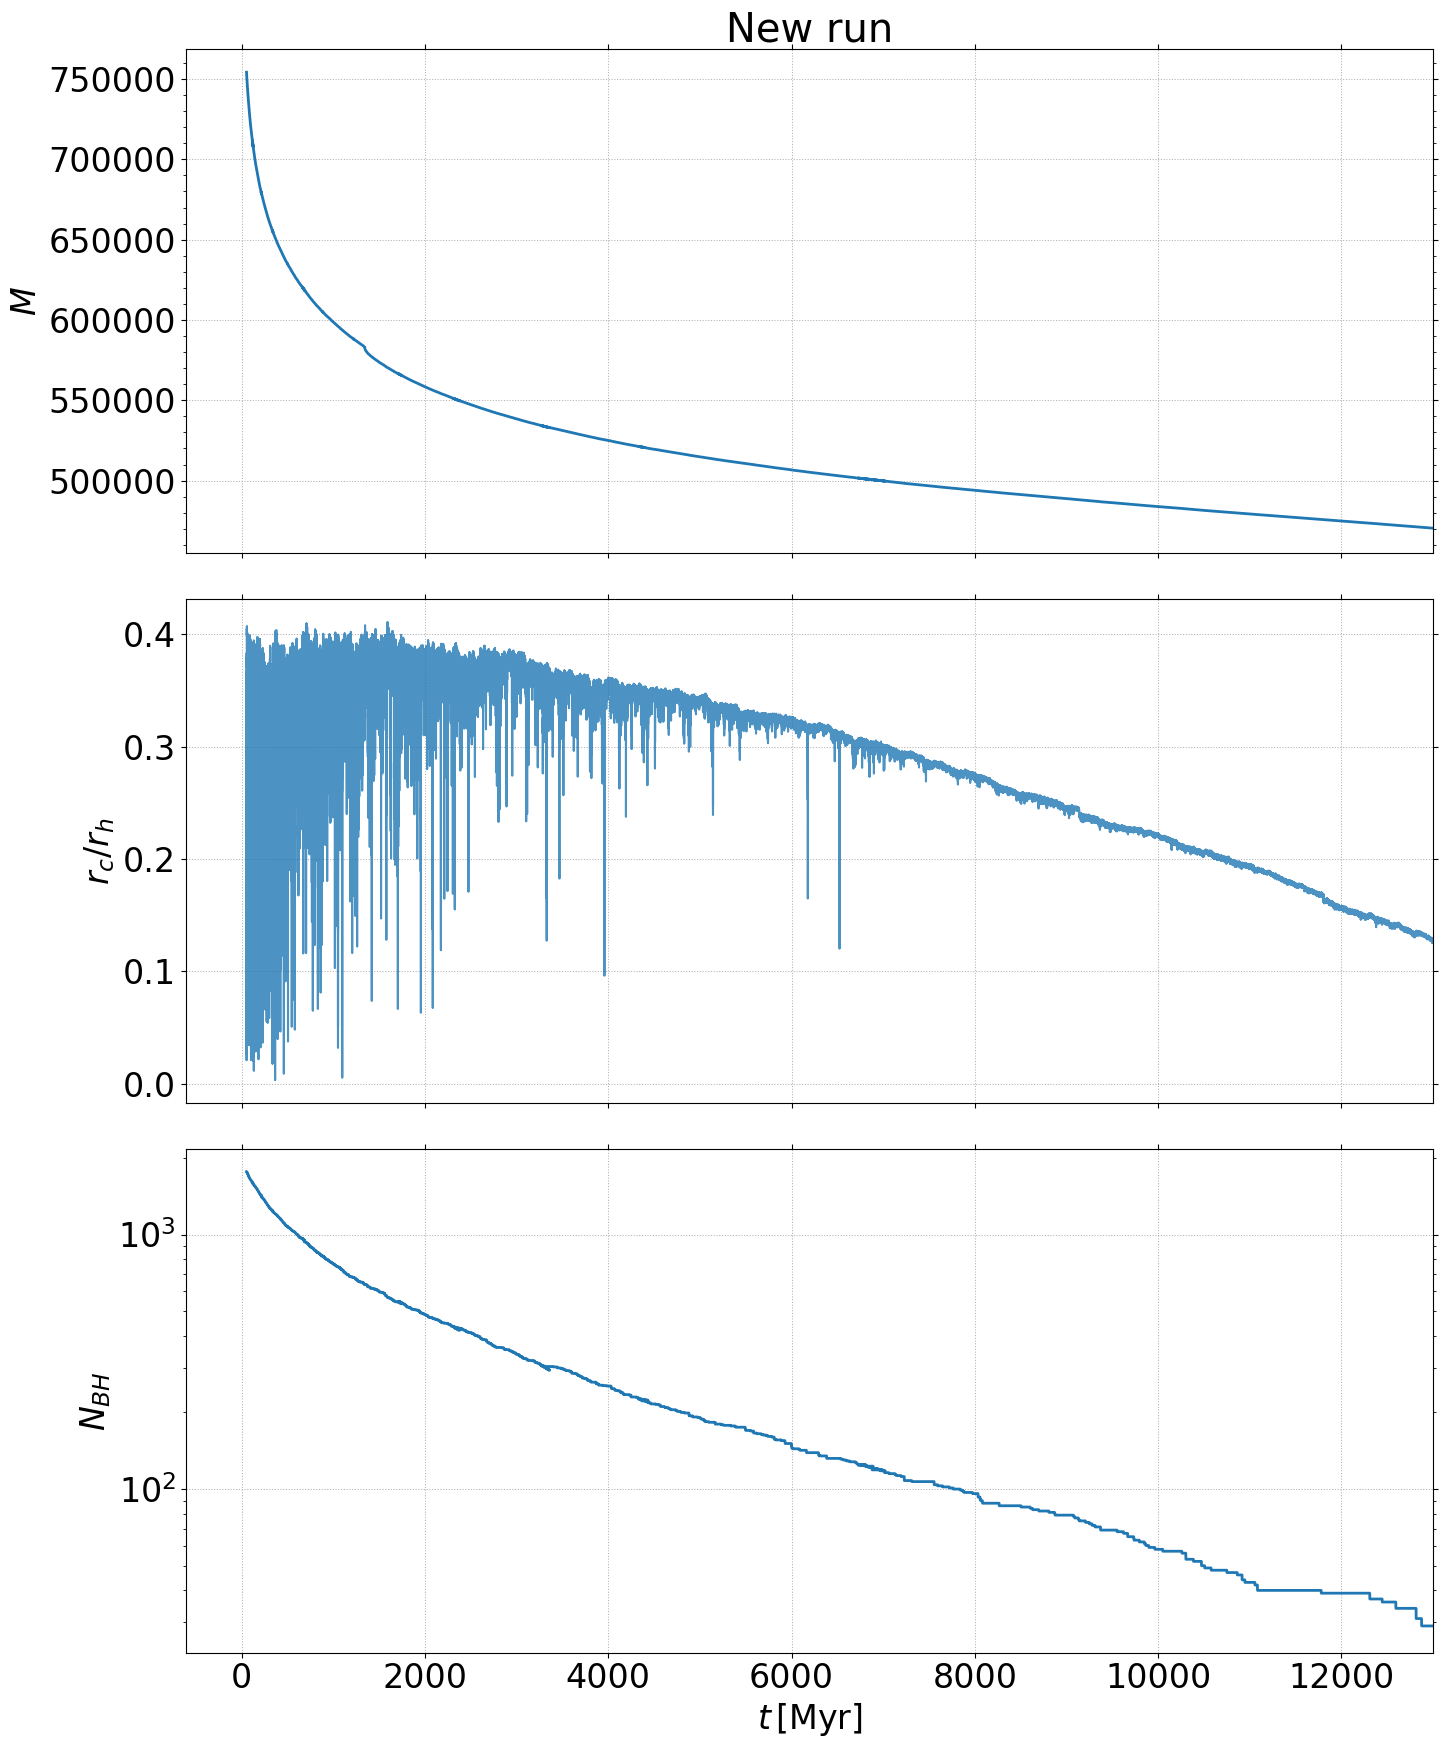

In [20]:
thepath = '/fs/lustre/cita/claireshiye/CMC-COSMIC/CMC/ngc1851/N1.6e6rv0.5z0.002rg20/'

t_conv = dyn.conv('t', thepath+'initial.conv.sh')
m_conv = dyn.conv('m', thepath+'initial.conv.sh')
l_conv = dyn.conv('l', thepath+'initial.conv.sh')

print(m_conv)

t_myr = []; m_msun = []
rc_pc = []; rh_pc = []

tbh_myr = []; nbh = []
for xx in range(1, 14):
    dynfile = thepath+'initial'+str(xx)+'.dyn.dat'
    with open(dynfile, 'r') as fdyn:
        next(fdyn); next(fdyn)
        
        for line in fdyn:
            data = line.split()
            t_myr.append(float(data[0])*t_conv)
            m_msun.append(float(data[4])*m_conv)
            rc_pc.append(float(data[7])*l_conv)
            rh_pc.append(float(data[20])*l_conv)
    
    print(xx)
    
    bhfile = thepath+'initial'+str(xx)+'.bh.dat'
    with open(bhfile, 'r') as fbh:
        next(fbh)
        
        for line in fbh:
            data = line.split()
            tbh_myr.append(float(data[1])*t_conv)
            nbh.append(int(data[2]))
    

fig, axs = plt.subplots(nrows=3, figsize=(15, 18),sharex=True)
axs[0].plot(t_myr, m_msun, lw=2)
axs[1].plot(t_myr, np.array(rc_pc)/np.array(rh_pc), alpha=0.8)
axs[2].plot(tbh_myr, nbh, lw=2)

#axs[0].set_yscale('log')
axs[0].set_ylabel(r'$M$')
axs[0].yaxis.set_minor_locator(AutoMinorLocator())
axs[0].grid(linestyle=':',which='major',linewidth='0.75')
#axs[0].grid(linestyle=':',which='minor',linewidth='0.75')
axs[0].xaxis.set_ticks_position('both')
axs[0].yaxis.set_ticks_position('both')
axs[0].set_xlim(xmax=13000)
axs[0].set_title('New run')

axs[1].set_ylabel(r'$r_c/r_h$')
axs[1].grid(linestyle=':',which='major',linewidth='0.75')
#axs[1].grid(linestyle=':',which='minor',linewidth='0.75')
axs[1].xaxis.set_ticks_position('both')
axs[1].yaxis.set_ticks_position('both')

axs[2].set_ylabel(r'$N_{BH}$')
axs[2].set_xlabel(r'$t\,$[Myr]')
axs[2].set_yscale('log')
axs[2].grid(linestyle=':',which='major',linewidth='0.75')
#axs[2].grid(linestyle=':',which='minor',linewidth='0.75')
axs[2].xaxis.set_ticks_position('both')
axs[2].yaxis.set_ticks_position('both')

fig.tight_layout()

In [9]:
path = '/fs/lustre/cita/claireshiye/CMC-COSMIC/CMC/ngc1851/N1.3e6rv0.5z0.0013rg20/'
snap_h5 = 'initial11.snapshots.h5'


with pd.HDFStore(path+snap_h5) as snap_hdf:
    snap_keys = np.sort(snap_hdf.keys())

print(snap_keys)    
#max_snapno = len(snap_keys)    
    
t_conv = dyn.conv('t', path+'initial.conv.sh')

def read_keys(thekey):
    return re.findall(r'\d+\.\d+|\d+', thekey)

snapno = []; snaptime = []
for ii in range(len(snap_keys)):
    theno = read_keys(snap_keys[ii])[0]; thetime = read_keys(snap_keys[ii])[1]
    snapno.append(int(theno)); snaptime.append(thetime)
    
snapno_sort, snaptime_sort = (np.array(t) for t in zip(*sorted(zip(snapno, snaptime))))
print(snapno_sort, snaptime_sort)
#np.savetxt(path[kk]+'snap_keys.txt',
#          np.c_[snapno_sort, snaptime_sort], fmt = '%s %s', header = '1.snap_no 2.snap_time', comments = '#')

HDF5ExtError: HDF5 error back trace

  File "H5F.c", line 836, in H5Fopen
    unable to synchronously open file
  File "H5F.c", line 796, in H5F__open_api_common
    unable to open file
  File "H5VLcallback.c", line 3863, in H5VL_file_open
    open failed
  File "H5VLcallback.c", line 3675, in H5VL__file_open
    open failed
  File "H5VLnative_file.c", line 128, in H5VL__native_file_open
    unable to open file
  File "H5Fint.c", line 1911, in H5F_open
    unable to lock the file
  File "H5FD.c", line 2412, in H5FD_lock
    driver lock request failed
  File "H5FDsec2.c", line 941, in H5FD__sec2_lock
    unable to lock file, errno = 11, error message = 'Resource temporarily unavailable'

End of HDF5 error back trace

Unable to open/create file '/fs/lustre/cita/claireshiye/CMC-COSMIC/CMC/ngc1851/N1.3e6rv0.5z0.0013rg20/initial11.snapshots.h5'

12.040608296372


/fs/lustre/cita/claireshiye/cmctoolkit/cmctoolkit.py:1099: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.filtertable = self.filtertable.append(filterrow, ignore_index=True)
/fs/lustre/cita/claireshiye/cmctoolkit/cmctoolkit.py:1099: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.filtertable = self.filtertable.append(filterrow, ignore_index=True)
/fs/lustre/cita/claireshiye/cmctoolkit/cmctoolkit.py:1099: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.filtertable = self.filtertable.append(filterrow, ignore_index=True)
/fs/lustre/cita/claireshiye/cmctoolkit/cmctoolkit.py:1099: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.

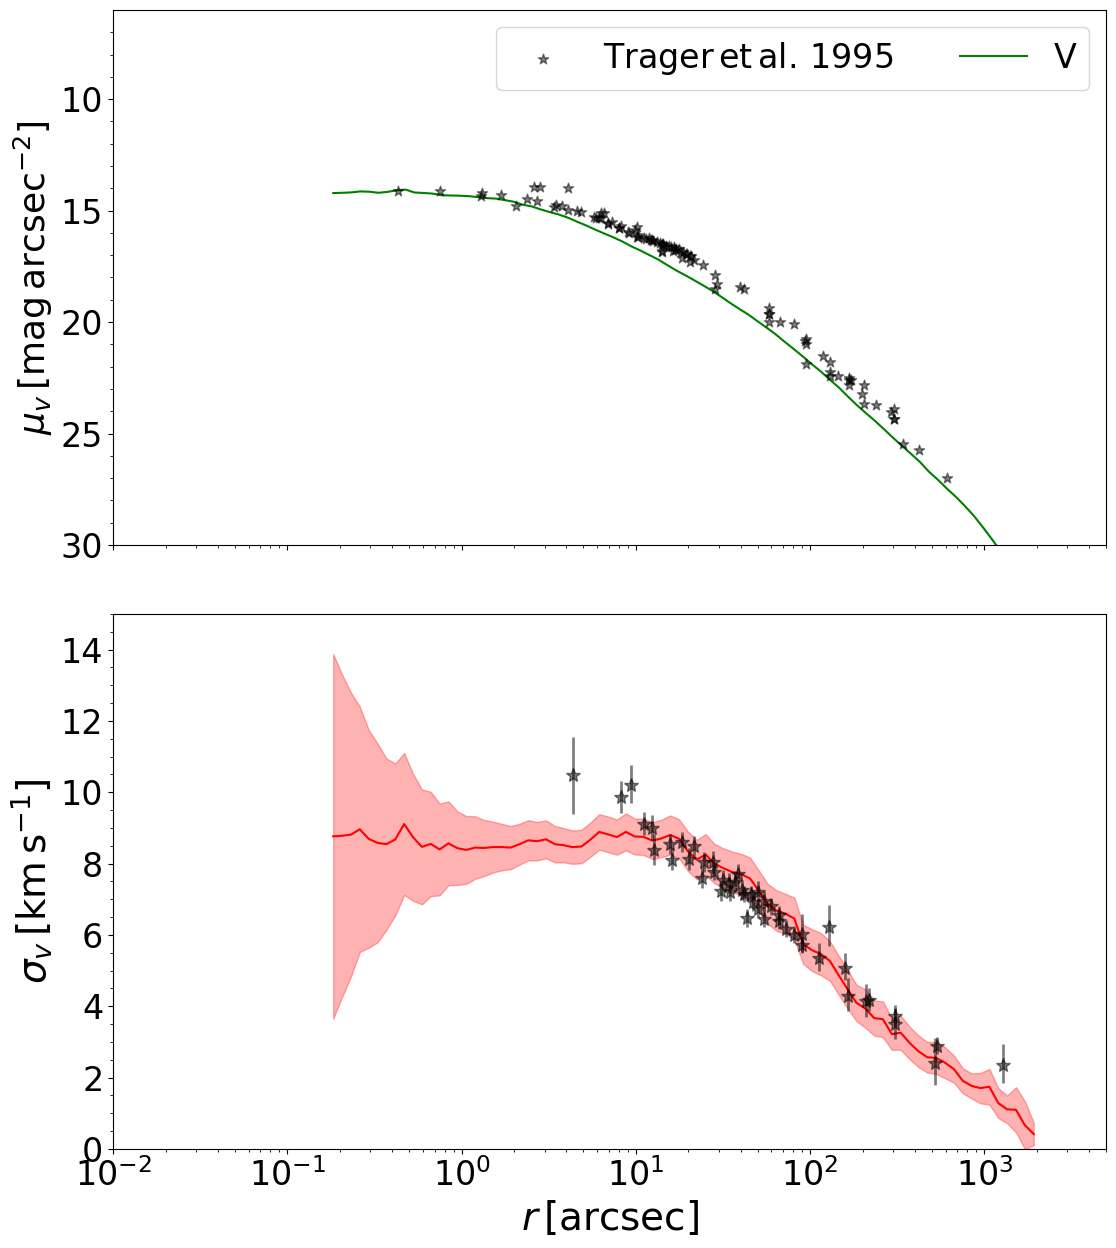

In [8]:
#path = '/fs/lustre/cita/claireshiye/CMC-COSMIC/CMC/ngc1851/N1.6e6rv0.5z0.002rg20/'
#snap_h5 = 'initial13.snapshots.h5'
#t: '/1424(t=13.495145)'

path = '/fs/lustre/cita/claireshiye/CMC-COSMIC/CMC/ngc1851/N1.3e6rv0.5z0.0013rg20/'
snap_h5 = 'initial11.snapshots.h5'
#t: '1413 14.749556'

snap = cmct.Snapshot(fname=path+snap_h5, snapshot_name='/1413(t=14.749556)', conv=path+'initial.conv.sh', 
                     dist=11.95, # distance to cluster in kpc
                     z=0.002)
print(snap.age)
##First Check

##Surface brightness and Velocity dispersion profile
d1851 = 11.95  ##kpc


###############################################
##Make surface brightness profile
snap.add_photometry('/fs/lustre/cita/claireshiye/cmctoolkit/filt_index.txt')
v_bincenter, v_profile = snap.make_smoothed_brightness_profile('V', bins=80,
                                                               min_mass=None, max_mass=None,
                                                               max_lum=15, fluxdict=None,
                                                               startypes=np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                                               min_logr=-2.0)


# Make velocity dispersion profiles
star_velbin_center, star_veldisp_profile, star_e_veldisp_profile = snap.make_smoothed_veldisp_profile(bins=80,
                                                                 min_mass=0.86,
                                                                 max_mass=None,
                                                                 dmax=None,
                                                                 fluxdict=None,
                                                                 startypes=np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                                                 min_logr=-2.0)

star_velbin_arcsec = conversions.pc_to_arcsec(star_velbin_center,d1851)


##Make number density profile
star_numbin_center, star_profile, star_e_profile = snap.make_smoothed_number_profile(bins=80,
                                                 min_mass=None,
                                                 max_mass=None,
                                                 fluxdict=None,
                                                 startypes=np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                                 min_logr=-2.0)

star_numbin_arcsec = conversions.pc_to_arcsec(star_numbin_center,d1851)
star_profile_arcsec = star_profile/(conversions.pc_to_arcsec(1.,d1851)**2)
star_e_profile_arcsec = star_e_profile/(conversions.pc_to_arcsec(1.,d1851)**2)


##Surface brightness and velocity dispersion profiles
###Observations###
R_sun_obs=11.95
ngcno='1851'

ft = open('makeSBP/trager.dat','r')
linest = ft.readlines()


fv = open('makeSBP/vel_dispersion_profiles_100423.dat','r')
linesv = fv.readlines()

flag = 0
#### find observed SBP from trager file
arcsec_t = []
SB_t = []
for k in range(len(linest)):
    linet = linest[k]
    linet = linet.split('\n')
    linet = linet[0]
    linet = linet.split('\t')
    cluster_tregar = linet[1]
    if cluster_tregar == 'ngc'+ngcno:
        arcsec_t.append(float(linet[2]))
        SB_t.append(float(linet[3]))
        flag = 1
arcsec_t = np.array(arcsec_t[:])
SB_t = np.array(SB_t[:])
if flag == 0:
        print('Trager doesnt have the SBP or sigma v profile')
        sys.exit()

flag = 0
#### find observed sigma_v profile
datav = np.genfromtxt('makeSBP/vel_dispersion_profiles_100423.dat')
R_obs = [] # in arcsec
sigma_obs = []
sigma_err_obs_up = []
sigma_err_obs_down = []
for k in range(len(linesv)):
    linev = linesv[k]
    linev = linev.split('\n')
    linev = linev[0]
    linev = linev.split(' ')
    cluster_sigma = linev[0]
    if cluster_sigma == 'NGC'+ngcno:
        R_obs.append(datav[k,1])
        sigma_obs.append(datav[k,2])
        sigma_err_obs_up.append(datav[k,3])
        sigma_err_obs_down.append(datav[k,4])
        flag = 1
R_obs = np.array(R_obs[:])
sigma_obs = np.array(sigma_obs[:])
sigma_err_obs_up = np.array(sigma_err_obs_up[:])
sigma_err_obs_down = np.array(sigma_err_obs_down[:])
############
if flag == 0:
        print('No observed sigmav profile')
        sys.exit()
        

fig, ax=plt.subplots(2, 1, sharex=True,  figsize=(12,13))
#ax[0].set_title(r'$\rm{NGC}\ $'+ngcno, fontsize=20)
ax[0].scatter(10**arcsec_t[:], SB_t[:], facecolor='k', marker = '*', 
              alpha=0.5, s=60, label=r'$\rm{Trager\,et\,al.\,1995}$', zorder=3)
ax[0].plot(v_bincenter, v_profile, c='g', label='V')

ax[1].errorbar(R_obs,sigma_obs,yerr=[sigma_err_obs_down,sigma_err_obs_up], fmt='*', 
               markersize = 10, alpha=0.5, c='k', lw=2.0, zorder=3)
ax[1].scatter([10000,10000], [-5,-5], c='k', marker = '*', alpha=0.5, s=60)
ax[1].plot(star_velbin_arcsec, star_veldisp_profile, c='r', label='Stars')
ax[1].fill_between(star_velbin_arcsec, star_veldisp_profile - star_e_veldisp_profile,
                                  star_veldisp_profile + star_e_veldisp_profile, color='r', alpha=0.3)


ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0].set_ylim(30,6)
ax[0].set_xscale('log')
ax[0].set_xlim(0.01,5000)
ax[0].set_ylabel(r'$\mu_v\,[\rm{mag\,arcsec^{-2}}]$',fontsize=26)
ax[0].legend(loc='best',scatterpoints=1, ncol=2, prop={'size': 24})

ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].set_xscale('log')
ax[1].set_xlim(0.01,5000)
ax[1].set_ylim(0, 15)
ax[1].set_xlabel(r'$r\,[\rm{arcsec}]$',fontsize=28)
ax[1].set_ylabel(r'$\sigma_v\,[\rm{km\,s^{-1}}]$',fontsize=28)
#ax[1].legend(loc=3,scatterpoints=1, ncol=2, prop={'size': 24})

plt.subplots_adjust(hspace=0.05)
fig.tight_layout()


/fs/lustre/cita/claireshiye/CMC-COSMIC/CMC/ngc1851/N1.3e6rv0.5z0.0013rg20/
/fs/lustre/cita/claireshiye/CMC-COSMIC/CMC/ngc1851/N1.3e6rv0.5z0.0013rg20/initial11.snap1397.2D_SBPLcut12_NCUT-1.dat
10999.4


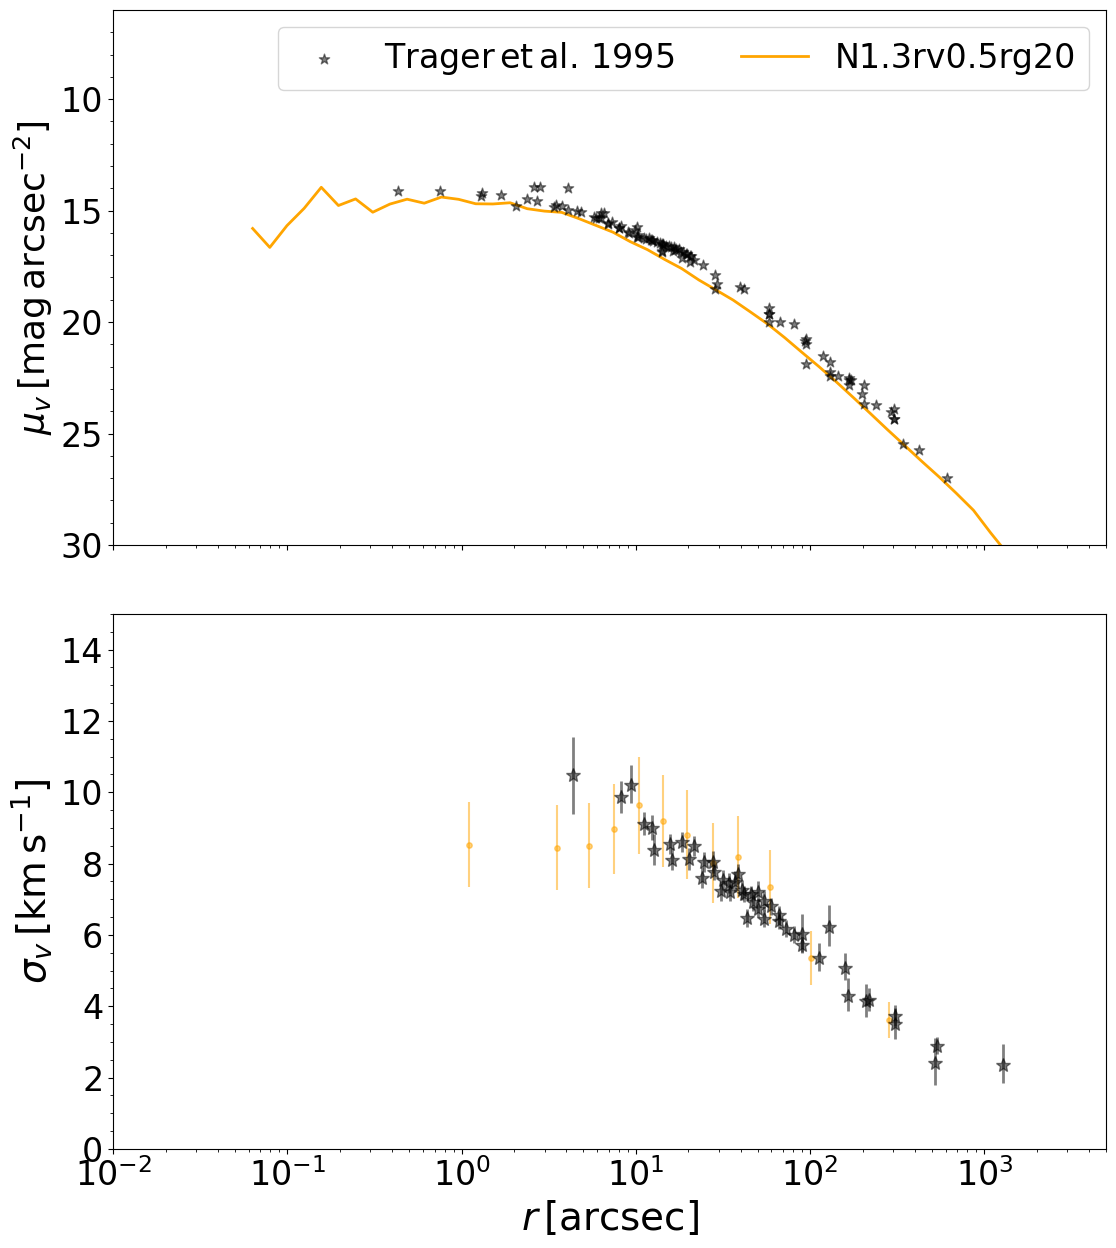

In [11]:
path = ['/fs/lustre/cita/claireshiye/CMC-COSMIC/CMC/ngc1851/N1.3e6rv0.5z0.0013rg20/']
prefix = ['initial11']

##Surface brightness and velocity dispersion profiles
###Observations###
R_sun_obs=11.95
ngcno='1851'

ft = open('makeSBP/trager.dat','r')
linest = ft.readlines()


fv = open('makeSBP/vel_dispersion_profiles_100423.dat','r')
linesv = fv.readlines()

flag = 0
#### find observed SBP from trager file
arcsec_t = []
SB_t = []
for k in range(len(linest)):
    linet = linest[k]
    linet = linet.split('\n')
    linet = linet[0]
    linet = linet.split('\t')
    cluster_tregar = linet[1]
    if cluster_tregar == 'ngc'+ngcno:
        arcsec_t.append(float(linet[2]))
        SB_t.append(float(linet[3]))
        flag = 1
arcsec_t = np.array(arcsec_t[:])
SB_t = np.array(SB_t[:])
if flag == 0:
        print('Trager doesnt have the SBP or sigma v profile')
        sys.exit()

flag = 0
#### find observed sigma_v profile
datav = np.genfromtxt('makeSBP/vel_dispersion_profiles_100423.dat')
R_obs = [] # in arcsec
sigma_obs = []
sigma_err_obs_up = []
sigma_err_obs_down = []
for k in range(len(linesv)):
    linev = linesv[k]
    linev = linev.split('\n')
    linev = linev[0]
    linev = linev.split(' ')
    cluster_sigma = linev[0]
    if cluster_sigma == 'NGC'+ngcno:
        R_obs.append(datav[k,1])
        sigma_obs.append(datav[k,2])
        sigma_err_obs_up.append(datav[k,3])
        sigma_err_obs_down.append(datav[k,4])
        flag = 1
R_obs = np.array(R_obs[:])
sigma_obs = np.array(sigma_obs[:])
sigma_err_obs_up = np.array(sigma_err_obs_up[:])
sigma_err_obs_down = np.array(sigma_err_obs_down[:])
############
if flag == 0:
        print('No observed sigmav profile')
        sys.exit()
        

fig, ax=plt.subplots(2, 1, sharex=True,  figsize=(12,13))
#ax[0].set_title(r'$\rm{NGC}\ $'+ngcno, fontsize=20)
ax[0].scatter(10**arcsec_t[:], SB_t[:], facecolor='k', marker = '*', 
              alpha=0.5, s=60, label=r'$\rm{Trager\,et\,al.\,1995}$', zorder=3)
ax[1].errorbar(R_obs,sigma_obs,yerr=[sigma_err_obs_down,sigma_err_obs_up], fmt='*', 
               markersize = 10, alpha=0.5, c='k', lw=2.0, zorder=3)
ax[1].scatter([10000,10000], [-5,-5], c='k', marker = '*', alpha=0.5, s=60)

###Models###
#cs=['cyan','b','g','purple','orange', 'r']
cs=['orange']
lbs = ['N1.3rv0.5rg20']
for xx in range(len(path)): #len(path)
    print(path[xx])
    snap2D = np.sort(glob(path[xx]+prefix[xx]+'.snap*.2Dproj.dat.gz'))
    snap2D_L12 = np.sort(glob(path[xx]+prefix[xx]+'.snap*.2D_SBPLcut12_NCUT-1.dat'))
    snap_vel700 = np.sort(glob(path[xx]+prefix[xx]+'.snap*.vel_dispersion_vr_pm_100_0.86.dat'))
 
    for ii in range(0, len(snap2D_L12)):
        with open(snap2D_L12[ii], 'r') as f2D:
            first_line=f2D.readline()

        t_gyr = float(first_line.strip().split('=')[-1])
        if t_gyr>=10990.:
            print(snap2D_L12[ii])
            print(t_gyr)
            data5 = np.genfromtxt(snap2D_L12[ii])
            arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs)
            SB = conversions.SB_converter(data5[:,3])
            SBerr = data5[:,6]/data5[:,5]*SB
            
            arcsec_cut = []
            SB_cut = []
            SBerr_cut = []
            for k in range(len(SB)):
                if arcsec[k] < 10 and SB[k] > 20:
                    Nothing = 0
                else:
                    arcsec_cut.append(arcsec[k])
                    SB_cut.append(SB[k])
                    #SBerr_cut.append(SBerr[k])
        
            datavel = np.genfromtxt(snap_vel700[ii])
            R_model = conversions.pc_to_arcsec(datavel[:,0],R_sun_obs)
            sigma_model = datavel[:,1]
            sigma_err_model = datavel[:,2]
        
            ax[0].plot(arcsec_cut, SB_cut, lw=2, label=lbs[xx], color=cs[xx])
            ax[0].plot([10000,10000],[-5,-5], lw=2)
            ax[1].scatter(R_model[::3], sigma_model[::3],s=15,zorder=2,alpha=0.5, color=cs[xx])
            ax[1].errorbar(R_model[::3],sigma_model[::3],yerr=2*sigma_err_model[::3], fmt='o',
                           markersize=0.01,zorder=1,alpha=0.5, color=cs[xx])

            break

ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0].set_ylim(30,6)
ax[0].set_xscale('log')
ax[0].set_xlim(0.01,5000)
ax[0].set_ylabel(r'$\mu_v\,[\rm{mag\,arcsec^{-2}}]$',fontsize=26)
ax[0].legend(loc='best',scatterpoints=1, ncol=2, prop={'size': 24})

ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].set_xscale('log')
ax[1].set_xlim(0.01,5000)
ax[1].set_ylim(0, 15)
ax[1].set_xlabel(r'$r\,[\rm{arcsec}]$',fontsize=28)
ax[1].set_ylabel(r'$\sigma_v\,[\rm{km\,s^{-1}}]$',fontsize=28)
#ax[1].legend(loc=3,scatterpoints=1, ncol=2, prop={'size': 24})

plt.subplots_adjust(hspace=0.05)
fig.tight_layout()

In [3]:
snap2d = '/fs/lustre/cita/claireshiye/CMC-COSMIC/CMC/ngc1851/N1.3e6rv0.5z0.0013rg20/initial11.snap1391.2Dproj.dat.gz'

mcut = 0
n=0; ng = 0
n_vdp = 0
with gzip.open(snap2d, 'r') as f2d:
    next(f2d); next(f2d)
    for line in f2d:
        data = line.split()
        if int(data[2])==1:
            if (int(data[5]) <10 and float(data[10])>=0.86) or (int(data[6]) <10 and float(data[11])>=0.86):
                n+=1
                
            if 2<=int(data[5])<=9 or 2<=int(data[6])<=9:
                ng+=1
                
            if mcut == 0 and (2<=int(data[5])<=9 or 2<=int(data[6])<=9):
                n_vdp+=1
        else:
            if int(data[3]) <10 and float(data[9])>=0.86:
                n+=1
            
            if 2<=int(data[3])<=9:
                ng+=1
                
            if mcut == 0 and 2<=int(data[3])<=9:
                n_vdp+=1
                
print(n)
print(ng)
print(n_vdp)

4054
3812
3812
